# __ASE MACE implementation__
This notebook contains the installation procedure and initial testing provided in the MACE [GitHub](https://github.com/ACEsuit/mace?tab=readme-ov-file#pretrained-foundation-models) and the [documentation](https://mace-docs.readthedocs.io/en/latest/). 

### __Installation procedure__
Refer to ASE installation for the basics of the miniconda `venv` where MACE will be installed. This ensures that other calculators will not break the environment.
- ASE installation process
    - Create new conda environment (python 3.10 is standard). Check the Python requirement for the external calculator wanted. Usually  `python>3.9`.  
    - `conda install ase` (installs `scipy` and `numpy` dependencies) and `conda install matplotlib`. 
    - Check the environment works installing `conda install pytest` and `ase test`.
    - For ASE representations inside Jupyter Notebook, conda install `notebook`, `ipywidgets` and `nglview`. 
- MACE installation process
    - Clone base ASE environment. 
    - Install [pytorch](https://pytorch.org/get-started/locally/) using conda via `conda install pytorch=2.2 torchvision -c pytorch` (preferred over pip install). 
    - MACE cannot be installed via conda, so `pip install --upgrade pip` and then `pip install mace-torch`. **Obs.** MACE uses numpy 1.26 and not 2.x. When installing MACE it is downgraded but no issues arise. 
    - The MACE-MP model with dispersion corrections (D3), require `torch-dftd`, which can be installed via `pip install torch-dftd`. 
    - **Issue.** I have no clue why but the directory `foundations_models` inside `mace/calculators` is not present, and if ani-cc based MACE model is used, an error will show up 'no .model found'. Solution: use DownGit to manually download the models. **Update.** This does not solve the issue, the .model in the repo is designed for CUDA in mind, and as I dont have an NVIDIA gpu... [issue](https://github.com/ACEsuit/mace/issues/656). When training a model, `--save_cpu` to be able to use the trained model on CPU, else it defaults to CUDA. 


### __References__
- MACE tutorials. Includes a model explanation and traning, evaluation examples. [RECOMMENDED]
    - https://github.com/imagdau/Tutorials

**Obs.** `mace.calculators` have the papers in the docstring, might be useful to know what paper to cite when using them. 


## __MACE pretrained models__
MACE provides an interface to ASE via a calculator class named `MACECalculator`. Predefined calculators with specific models can be found in `mace.calculators`. Analyzing the `__init__`, we can see that MACE includes several pretrained foundational models in `foundations_models.py`. The `MACECalculator` class can be found in `mace.py` and includes a detailed description on its methods 

- `mace_anicc`
    - Returns a MACECalculator object pretrained on the ANI CC dataset (H, C, N, O).
    - Note that the name ANI-1ccx is reserved for the TorchANI implementation of the ANI model on the ANI CC dataset. 
    - Defaults to `device=cuda`.  

- `mace_mp`
    - Constructs a MACECalculator with a pretrained model based on the Materials Project (89 elements). The [MACE-MP models](https://github.com/ACEsuit/mace-mp) (available in the corresponding repo) include different training datasets, and model sizes, as well as certain architectural improvements depending on the model used. [Citations are available]. 

- `mace_off`
    - Constructs a MACECalculator with a pretrained model based on the MACE-OFF23 models. The [MACE-OFF models](https://github.com/ACEsuit/mace-off) (available in the corresponding repo) are intended for organic molecules, and as such, would be interesting to compare to ANI-X models. 

As well as `MACECalculator`. 

In [ ]:
# ase imports
from ase import units

# import the calculators
from mace.calculators import mace_anicc, mace_mp, mace_off
from mace.calculators import MACECalculator

#=======================#
#       CALCULATORS     #   
#=======================#

macemp = mace_mp(
    # core parameters
    device='cpu',               # 'cpu', 'cuda'
    model='medium',             # path to the model, or size
    default_dtype='float32', 

    # dispersion corrections
    dispersion=True,                    # include D3 dispersion corrections. 
    damping='bj',                       # damping function associated with the D3 correction
    dispersion_xc='pbe',                # exchange-correlation functional for D3 dispersion corrections
    dispersion_cutoff=40.0*units.Bohr,  # cutoff radius in Bohr for D3 dispersion corrections
    )

maceoff = mace_off(
    # core parameters
    device='cpu',               # 'cpu', 'cuda'
    model='medium',             # path to the model or size
    default_dtype='float32', 
)

# only CUDA
#maceani = mace_anicc(
#    # core parameters
#    device='cpu',
#    )

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


## __1. ASE MACE calculator usage__
Basic tests with the pretrained models interfaced with ASE. Note that the MACE model based on the ANI-CC dataset is only available for CUDA and hence could not be tested.

### __H2O single point calculation and atomization energy__
Comparison of two different calculators (MACE-MP and MACE-OFF models). 

In [2]:
# ase
from ase import build

# mace
from mace.calculators import mace_mp, mace_off

In [3]:
atoms = build.molecule('H2O')


macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float64", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float64'
    )

atoms.calc = macemp
macemp_H2O_energy = atoms.get_potential_energy()
print(f'H2O energy @ MP (medium):\t{macemp_H2O_energy}')

atoms.calc = maceoff
maceoff_H2O_energy = atoms.get_potential_energy()
print(f'H2O energy @ OFF (medium):\t{maceoff_H2O_energy}')

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
H2O energy @ MP (medium):	-14.15936617752067
H2O energy @ OFF (medium):	-2081.11639716893


In [4]:
# check the energy of formation of the H2O molecule
calc_list = [macemp, maceoff]
atomic_energies = []

k = 0
for calc_ in calc_list:
    # define the atoms
    atom_O = build.molecule('O')
    atom_H = build.molecule('H')

    atom_O.calc = calc_
    atom_H.calc = calc_

    energy_H = atom_H.get_potential_energy()
    energy_O = atom_O.get_potential_energy()
    atomic_energies.append([energy_H, energy_O])

    k += 0

# check the results
delta_E_formation_MP = macemp_H2O_energy - (2 * atomic_energies[0][0] + atomic_energies[0][1])
delta_E_formation_OFF = maceoff_H2O_energy - (2 * atomic_energies[1][0] + atomic_energies[1][1])

print(atomic_energies)
print(f'H2O energy formation @ MP (medium):\t{delta_E_formation_MP:.3f} [units?]')
print(f'H2O energy formation @ OFF (medium):\t{delta_E_formation_OFF:.3f} [units?]')
print(f'H2O energy of water @ CCSD(T):\t\t-75.013 Hartree')

[[-1.1589879653522117, -2.081460506806864], [-13.571964772646918, -2043.933693071156]]
H2O energy formation @ MP (medium):	-9.760 [units?]
H2O energy formation @ OFF (medium):	-10.039 [units?]
H2O energy of water @ CCSD(T):		-75.013 Hartree


What energy units are the models predicting?

### __H2O MD NVT simulation__
This simulation ([reference](https://mace-docs.readthedocs.io/en/latest/examples/foundation_examples.html)) uses the MACE-MP foundational model as NNP as the MD FF. 

In [5]:
from mace.calculators import mace_mp, mace_off, mace_anicc, MACECalculator
from ase import build
from ase.md import Langevin
from ase.io.trajectory import Trajectory
from ase.visualize import view
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units

# MD settings
T_init = 300 
n_steps = 200

macemp = mace_mp(
    device='cpu', 
    model='medium', 
    default_dtype='float32',   
    )

atoms = build.molecule('H2O')
atoms.calc = macemp

MaxwellBoltzmannDistribution(atoms, temperature_K=T_init*units.kB)

traj = Trajectory('water_nvt.traj', 'w', atoms)

# NVT
dyn = Langevin(atoms, 0.5 * units.fs, temperature_K=T_init*units.kB, friction=0.001)
dyn.attach(traj.write, interval=1)
dyn.run(n_steps)

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


True

In [6]:
traj = Trajectory('water_nvt.traj')
view(traj, viewer='ngl')

### __H2 diatomic potential__
Here we compute the PES of a diatomic molecule, H2 with the MACE-OFF and MACE-MP NNP. 

In [7]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase import Atoms
from ase.visualize import view

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


In [13]:
def evaluate_diatomics(atom_str, calculator_list, search_space=None , resolution=None, verbose=True):
    '''
    Definition
    ----------
    Evaluates the PES of simple (homoatomic) diatomic molecules A_2. 

    '''

    if resolution is None:
        resolution = 100

    if search_space is None:
        search_space = [0.3, 6.5]
    dist_list = np.linspace(search_space[0], search_space[1], resolution)

    print(f'computing {atom_str}2 PES\tscan range {search_space} Å')

    # save energies
    energies = []

    # evaluate each calculator
    for calc_ in calculator_list: 

        calc_energy_list = []

        for d in dist_list:

            # define the configuration
            atoms = Atoms(atom_str + '2', [[0, 0, 0], [0, 0, d]])
            atoms.calc = calc_
            E_pot = atoms.get_potential_energy()
            calc_energy_list.append(E_pot)
        
        atom = Atoms(atom_str)
        atom.calc = calc_
        atom_dissociated = 2 * atom.get_potential_energy()
        corrected_energies = np.array(calc_energy_list) - atom_dissociated

        energies.append(corrected_energies)

    return dist_list, energies


def plot_diatomics(atom_str_list, calculator_names, global_energies, global_distances, workdir='./'):
    '''
    Plot the different PES obtained via `evaluate_diatomics`. 
    '''

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12,4))
    ax_list = axes[0], axes[1], axes[2], axes[3]
    #ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]

    for i in range(len(atom_str_list)):
        ax_list[i].tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax_list[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

        for k in range(len(calculator_names)):
            #label=r'$\textnormal{' + calculator_names[k] + r'}$'
            ax_list[i].plot(global_distances[i], global_energies[i][k][:], label=calculator_names[k], color=calculator_colors[k], alpha=0.9)

        #xlabel=r'$\textnormal{bond distance}\;\textnormal{(Å)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$'
        ax_list[i].set(xlabel=f'{atom_str_list[i]}-{atom_str_list[i]} bond distance (Å)', ylabel='potential energy (eV)')
        ax_list[i].legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(workdir, 'diatomics_PES.png'), dpi=300)
    plt.show(fig)

computing H2 PES	scan range [0.3, 6.5] Å
computing C2 PES	scan range [0.7, 6.5] Å
computing N2 PES	scan range [0.7, 6.5] Å
computing O2 PES	scan range [0.9, 6.5] Å


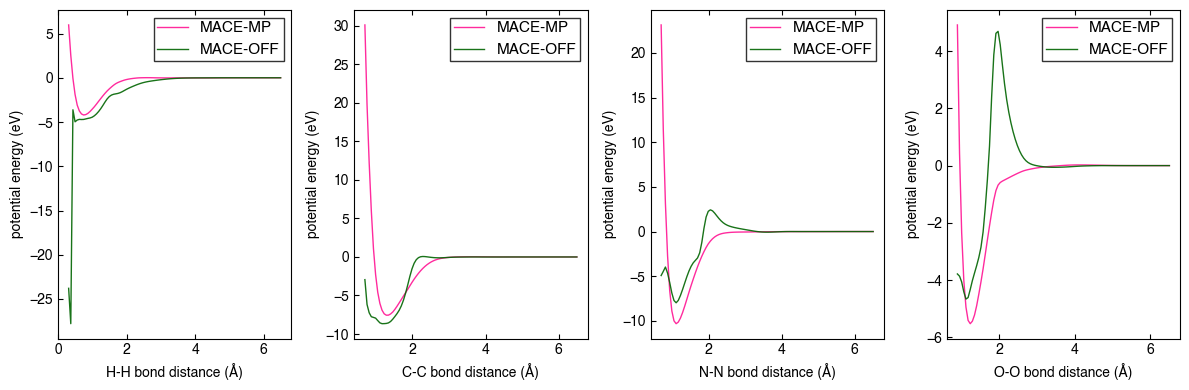

In [ ]:
# calculator 
from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float64", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float64'
    )

# define the calculators
calculator_list = [macemp, maceoff]
calculator_names = ['MACE-MP', 'MACE-OFF']
calculator_colors = ['deeppink', 'darkgreen']


# define the diatomics and the PES scan range
atom_str_list = ['H', 'C', 'N', 'O']
search_list = [[0.3, 6.5], [0.7, 6.5], [0.7, 6.5], [0.9, 6.5]]
workdir = './'

# dimension: [atom_len, calc_len, resolution]
global_energies = []

# dimension: [atom_len, resolution]
global_distances = []

# compute all the PES
for i in range(len(atom_str_list)):
    dist_list, energies = evaluate_diatomics(atom_str_list[i], calculator_list, search_space=search_list[i])
    global_energies.append(energies)
    global_distances.append(dist_list)

plot_diatomics(atom_str_list, calculator_names, global_energies, global_distances, workdir=workdir)

#### __Interpretació__
Això són deformacions covalents. La gran majoria de models estan entrenats amb un training set que no contempla aquestes estructures d'elevada energia (no són representatives al training set). Seria d'esperar que deformacions d'enllaços estiguessin pitjor descrites respecte 'soft degrees of freedom', com són angles i torsions. 

Vibracions training set, el minim d'energia es preveu correctament, probablemente degut al training set. 
No es pot aplicar aquest NNP per dissociacions d'àtoms. 

Comprovar l'età i fer la deformació. Molt probablement no sigui problema de l'entorn (valència).

Comprovar mateix training set 

FF ja se quina és les aproximacions fetes. 

## __2. Training MACE models__
While training models is not the ultimate goal, several examples on how to train and evaluate a MACE model with different datasets can be found [in the documentation](https://mace-docs.readthedocs.io/en/latest/examples/training_examples.html). Additional [tutorials](https://mace-docs.readthedocs.io/en/latest/examples/tutorials.html) are available, such as a [collab notebook](https://colab.research.google.com/drive/1ZrTuTvavXiCxTFyjBV4GqlARxgFwYAtX) for training and evaluating a model, and other tutorials for fine-tuning a pretrained model and MACE model theory. 


MACE offers the possibility to train a model within the MACE architecture given some training data. Extensive tutorials on how to train the model can be found [here](https://mace-docs.readthedocs.io/en/latest/examples/tutorials.html). A basic [introductory tutorial](https://colab.research.google.com/drive/1ZrTuTvavXiCxTFyjBV4GqlARxgFwYAtX) is provided.  

**Simple run.** A simple training and MD run was performed in [this]() Collab Notebook, which corresponds to the [ASE calculator](https://mace-docs.readthedocs.io/en/latest/guide/ase.html) section of the documentation. 